In [14]:
from GKFL0 import *
data_path = "./burgers"

# Does linear regression work? Yes!

In [15]:
def load_data(path):
    """
    This function loads the data

    Inputs:
    path= path to the pickle file that stores the data in the form of a python dictionary

    Outputs:
    u,x,t,dx,dt

    """
    file_to_read = open(path, "rb")
    loaded_dictionary = pickle.load(file_to_read)
    u = loaded_dictionary["u"]
    x = loaded_dictionary["x"]
    t = loaded_dictionary["t"]
    dx = x[2]-x[1]
    dt = t[2]-t[1]

    return u,x,t

In [16]:
# ========================== Smoothing ===========================
    
def smooth(u,x,t,sigma=6):
    """
    This function smooths the u matrix while keeping x and t the same.

    Inputs:
    u: The u matrix that is to be smoothed
    x: x values
    t: t values
    n: number of times initial gaussian filter is to be applied
    sigma: sigma value to be used in the initial gaussian filter
    m: number of times we need to perform KNN_Gaussian
    sigma_k: sigma_k[i][0] refers to the sigma value in the first gaussian filter of KNN_Gaussian for ith execution of KNN_Gaussian
             sigma_k[i][1] refers to the num of neighbours in the KNN regression of KNN_Gaussian for ith execution of KNN_Gaussian
             sigma_k[i][2] refers to the 
             sigma value in the second gaussian filter of KNN_Gaussian for ith execution of KNN_Gaussian

    Output: 
    The smoothed u matrix
    """
    u_cap=gaussian_filter(u,sigma=sigma)
    print(u_cap.shape)
    return u_cap

In [17]:
# =============== Finding derivatives ============================

def derivatives(u,x,t,deg=3,width=9):
    """

    Finds the derivatives of u numerically using polynomial interpolation

    Inputs:
    u=u matrix
    x=x values
    t=t values
    deg=degree of the polynomial in polynomial interpolation
    width=no of points that are considered for interpolation (should be odd)

    Outputs:
    u = u matrix without the boundary points
    ut = time derivative of u
    ux = space derivative of u
    uxx = 2nd space derivative of u

    """
    if width%2==0:
        return "Error: Width to be used in polynomial interpolation should be odd so that we split the left and right points evenly"

    t_leni,x_leni = u.shape
    t_len=t_leni-(width)+1 # t_len and x_len decreases because we neglect the terms at the end
    x_len=x_leni-(width)+1 

    ut = np.zeros((t_len,x_len))
    ux = np.zeros((t_len,x_len))
    uxx = np.zeros((t_len,x_len))
    uxxx = np.zeros((t_len,x_len))
    w=width//2  # number of points taken on each side
    for i in range(x_len):
        ut[:,i] = interpolate(u[:,i+w], t, diff=1,deg=deg,width=width)[:,0]
    for i in range(t_len):
        der=interpolate(u[i+w,:], x, diff=3,deg=deg,width=width)
        ux[i,:] = der[:,0]
        uxx[i,:] = der[:,1]
        uxxx[i,:] = der[:,2]
    u=u[w:t_leni-w,w:x_leni-w]

    ut = np.reshape(ut, ((t_len)*(x_len),1), order='F')
    ux = np.reshape(ux,  ((t_len)*(x_len),1), order='F')
    uxx = np.reshape(uxx,  ((t_len)*(x_len),1), order='F')
    uxxx = np.reshape(uxxx,  ((t_len)*(x_len),1), order='F')
    return u,ut,ux,uxx,uxxx


def interpolate(u,x,deg,width,diff):    
    """
    u = values of a function
    x = x-coordinates where values are known
    deg=degree of the polynomial in polynomial interpolation
    width=no of points that are considered for interpolation (is odd)
    diff=max order of derivative to be calculated
    """
    
    u = u.flatten()
    x = x.flatten()

    n = len(x)
    du = np.zeros((n - width+1,diff))
    w=width//2
    
    for j in range(w, n-w):
        points = np.arange(j - w, j + w+1)
        # Polynomial interpolation: Least-squares fit
        poly = np.polynomial.polynomial.Polynomial.fit(x[points],u[points],deg)
        # Taking derivatives
        for d in range(1,diff+1):
            du[j-w, d-1] = poly.deriv(m=d)(x[j])
    return du

In [5]:
# Burgers equation ut = 0.1uxx -1 uux
c1, x, t = load_data(data_path + '/2_0.pkl')
c1, c1t, c1x, c1xx, c1xxx = derivatives(c1, x, t)
c1r = np.reshape(c1, (93 * 248, 1), order='F')

In [6]:
c1.shape

(93, 248)

In [7]:
t.shape

(101,)

# Correlations in Burgers Equation?

In [8]:
X, y, desc = library(c1r, c1t, c1x, c1xx, c1xxx)
y = y.reshape((len(y),)) 

C:\Users\MelPr\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2829: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
C:\Users\MelPr\AppData\Roaming\Python\Python38\site-packages\numpy\lib\function_base.py:2830: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


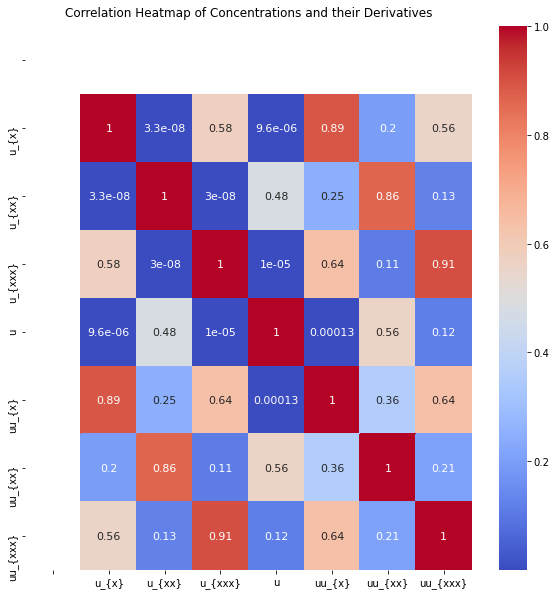

In [13]:
import seaborn as sns
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X)
corr = np.corrcoef(Xs.T)
plt.figure(figsize=(10, 10))
sns.heatmap(np.abs(corr), annot=True, cmap='coolwarm', xticklabels=desc, yticklabels=desc, annot_kws={"fontsize":11})
plt.title("Correlation Heatmap of Concentrations and their Derivatives", pad=10)
plt.show()

In [11]:
u, s, v = np.linalg.svd(Xs, full_matrices=False)
s

array([268.3969591 , 235.1935685 , 132.65775256, 110.04371839,
        47.79852018,  35.15269924,  29.44397417,   0.        ])

In [12]:
print(Xs.shape[1] - np.linalg.matrix_rank(Xs))

1


# Does linear regression work?

In [41]:
from sklearn.linear_model import LinearRegression

Xlr = np.hstack([c1xx, np.multiply(c1r, c1x)])
y = c1t
model = LinearRegression(fit_intercept=False).fit(Xlr, y)
print(model.coef_, model.intercept_) 

[[ 0.10524055 -0.99624821]] 0.0


In [68]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error as mse

model = LinearRegression(fit_intercept=True).fit(Xlr, y)
print(model.coef_, model.intercept_) 
ypredl0 = model.predict(Xlr)
print(r2_score(ypredl0, y), mse(ypredl0, y, squared=False)/np.median(y))

[[ 0.10524055 -0.99624821]] [4.5713538e-08]
0.9992963206514137 592.0971249596953


In [43]:
import statsmodels.api as sm
alpha = 0.05
lr = sm.OLS(y, Xl0).fit()
lr.conf_int(alpha)

array([[ 0.10515867,  0.10532242],
       [-0.99659634, -0.99590008]])

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:ylabel='Density'>

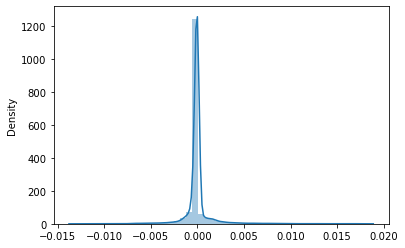

In [60]:
import seaborn as sns
resid = lr.resid
sns.distplot(resid)

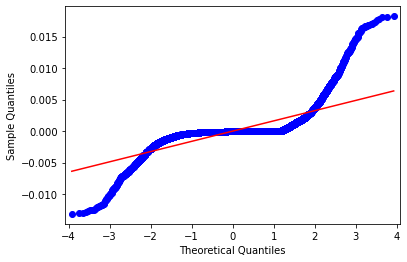

In [63]:
norm = np.random.normal(2, 10, (1000,))
sm.qqplot(resid, line='s')
plt.show()

In [66]:
from scipy.stats import kurtosis
kurtosis(resid)

33.04359383015209

In [48]:
X = np.hstack([c1r, c1x, c1xx, c1xxx, np.multiply(c1r, c1x), np.multiply(c1r, c1xx), np.multiply(c1r, c1xxx)])
y = c1t
model = LinearRegression(fit_intercept=False).fit(X, y)
print(model.coef_, model.intercept_) 
ypredl0 = model.predict(X)
print(r2_score(ypredl0, y), mse(ypredl0, y, squared=False)/np.median(y))

[[ 2.33760124e-03 -2.22005471e-04  1.06186799e-01  3.29957092e-03
  -1.00843775e+00  4.95346468e-03 -8.97192471e-03]] 0.0
0.9998030228074355 313.3445541009108


In [49]:
import statsmodels.api as sm
alpha = 0.05
l = sm.OLS(y, Xl0).fit()
l.conf_int(alpha)

array([[ 0.10515867,  0.10532242],
       [-0.99659634, -0.99590008]])

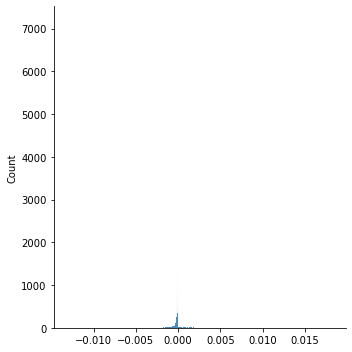

In [58]:
import seaborn as sns
resid = l.resid
sns.displot(resid)
plt.show()

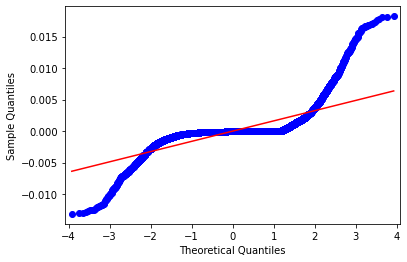

In [57]:
norm = np.random.normal(2, 10, (1000,))
sm.qqplot(resid, line='s')
plt.show()

# Are the derivatives calculated correctly? Yes!

In [18]:
t = np.linspace(0, 1, 700)
x = np.linspace(0, 1, 700)
w = 1
x1, t1 = np.meshgrid(x, t)
u = (np.sin(w * x1) + np.cos(w * x1)) * (np.exp(-t1))

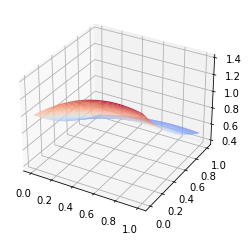

In [19]:
from matplotlib import cm
fig, ax = plt.subplots(subplot_kw={"projection": "3d"})


ax.plot_surface(x1, t1, u, cmap=cm.coolwarm, linewidth=0, antialiased=True)
plt.show()

In [20]:
u.shape

(700, 700)

In [21]:
u, ut, ux, uxx, uxxx = derivatives(u, x, t)

In [26]:
from sklearn.linear_model import LinearRegression

Xlr = np.hstack([uxx])
y = ut
model = LinearRegression(fit_intercept=False).fit(Xlr, y)
print(model.coef_, model.intercept_) 

[[1.0000028]] 0.0


In [27]:
X = np.hstack([u.reshape((u.shape[0] * u.shape[1], 1)), ux, uxx, uxxx])
X.shape

(478864, 4)

In [29]:
from sklearn.preprocessing import StandardScaler
Xs = StandardScaler().fit_transform(X)

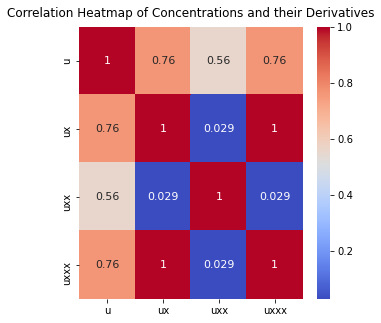

In [32]:
import seaborn as sns
corr = np.corrcoef(Xs.T)
plt.figure(figsize=(5, 5))
sns.heatmap(np.abs(corr), annot=True, cmap='coolwarm', xticklabels=['u', 'ux', 'uxx', 'uxxx'], yticklabels=['u', 'ux', 'uxx', 'uxxx'], annot_kws={"fontsize":11})
plt.title("Correlation Heatmap of Concentrations and their Derivatives", pad=10)
plt.show()

In [17]:
u, s, v = np.linalg.svd(Xs, full_matrices=False)
s

array([2.53394901e+02, 2.10782994e+02, 5.17837162e+01, 4.95377256e-08,
       1.63897021e-10])

# Does L0BnB recover Burgers Equation? Yes!

In [5]:
# Burgers equation ut = 0.1uxx -1 uux

pred_coefficients=[]

snrs = ["No noise"]

for j in range(len(snrs)):
    print("="*100)
    print("SNR = ",snrs[j])

    # Loading u,x,t
    path = data_path+"/2_"+str(29)+".pkl"
    sols,descr = discover_pde(path,sigma=6)
    print("\nPDEs Predicted by GKFL0: ")
    for i in range(len(sols)):
        print(return_pde(sols[i]["B"], descr))
    
    # Desired PDE
    w= sols[1]["B"]
    print("\nDesired PDE: ", return_pde(w, descr))
    pred_coefficients.append([snrs[j]]+list(w))

SNR =  No noise
(101, 256)
Preprocessing Data.
BnB Started.
Iteration: 1. Number of non-zeros:  1
Iteration: 2. Number of non-zeros:  2
Iteration: 3. Number of non-zeros:  3
Iteration: 4. Number of non-zeros:  5

PDEs Predicted by GKFL0: 
u_t = (-0.289954)u_{x}
u_t = (0.108011)u_{xx} + (-0.843328)uu_{x}
u_t = (-0.123734)u_{x} + (0.093712)u_{xx} + (-0.532303)uu_{x}
u_t = (-0.122883)u_{x} + (0.069888)u_{xx} + (-0.590141)uu_{x} + (0.074652)uu_{xx} + (-0.043987)u^2u_{xxx}

Desired PDE:  u_t = (0.108011)u_{xx} + (-0.843328)uu_{x}


# Does MATLAB data give mistakes? No!

In [76]:
import pandas as pd

In [77]:
def load_data(file):
    """
    This function loads the data.
    
    X = 300, T = 200
    
    Inputs:
        file    :    CSV file of shape (X, T) of the non-dimensional length and time. Take 0 <= X, T <= 1.
    
    Returns:
        u       :    Numpy Array of shape (T, X) of the data
        x       :    Numpy Array of shape (X,)
        t       :    Numpy Array of shape (T,)
        dx      :    1/400
        dt      :    1/300
    """
    file_to_read = pd.read_csv(file, index_col=False, header=None)
    u = np.array(file_to_read)
    x = np.linspace(0, 1, 300)
    t = np.linspace(0, 1, 200)

    return u, x, t

In [78]:
data_path = './pfr/'
c1, x, t = load_data(data_path + 'heat.csv')
c1, c1t, c1x, c1xx, c1xxx = derivatives(c1, x, t)

In [79]:
from sklearn.linear_model import LinearRegression

Xlr = np.hstack([c1xx])
y = c1t
model = LinearRegression(fit_intercept=False).fit(Xlr, y)
print(model.coef_, model.intercept_) 

[[0.99625751]] 0.0
